In [32]:
using LinearAlgebra
using Plots
using PrettyTables

#funkcje pomocnicze
function  h(i, X)
    return X[i+1] - X[i]
end

function Δ(i, X, Y)
    return  (Y[i+1] - Y[i]) / h(i, X)
end

function find(x, X)
    if x < X[1]
        return 1
    end
    for (i, xᵢ) in enumerate(X)
        if x < xᵢ
            return i-1
        end
    end
    if x >= X[end]
        return length(X)-1
    end
end


## Funkcja przydzielona na zajęciach

In [153]:
k = 4
m = 1
A = -4*pi
B = 3*pi
my_func = (x) -> exp(-k*sin(m*x)) + k*sin(m*x) - 1
# my_derivate = (x) -> (exp(-k*sin(m*x))*(-k*m*cos(m*x)) + k*m*cos(m*x))
xs = -4*pi:0.01:3*pi

plot(xs, my_func)
# savefig("plots/givenFunc")
# plot!(xs, my_derivate, lc="green")

"/home/ciastek/Dokumenty/studia/MoWNiT/MOwNiT/lab3/plots/givenFunc.png"

## Funkcja sklejana 3-go stopnia

In [114]:
# funkcje wypełniające brzegi w zalerzności od warunku brzegowego:

function clamped_boundary(A, b, x, y)
    n = length(x)
    h1 = h(1, x)
    hn = h(n-1, x)
    Δ1 = Δ(1, x, y)
    Δn = Δ(n-1, x, y)

    A[1,1] = 2*h1
    A[1,2] = h1
    b[1] = 3*(Δ1 - 2*h1*y[1])

    A[n,n-1] = hn
    A[n,n] = 2*hn
    b[n] = 3*(2*hn*y[n] - Δn)
end

function not_a_knot_boundary(A, b, x, y)
    n = length(x)
    h1 = h(1, x)
    h2 = h(2, x)
    hn1 = h(n-2, x)
    hn = h(n-1, x)
    Δ1 = Δ(1, x, y)
    Δ2 = Δ(2, x, y)
    Δn1 = Δ(n-2, x, y)
    Δn = Δ(n-1, x, y)

    A[1,1] = (h2 + h1)*hn^2
    A[1,2] = h1*h2*hn + h1^2*hn + h2^2*hn
    A[1,3] = -h1^2*hn
    b[1] = 3*((Δ2 - Δ1)*hn^2 - Δ1*h1^2 - Δ2*h2^2)

    A[n,n-2] = -hn1^2
    A[n,n-1] = h2*h1*hn1 + h2^2*hn1 + h1^2*hn1
    A[n,n] = (h2 + hn1)*h1^2
    b[n] = 3*((Δn1 - Δn)*h1^2 - Δn*hn1^2 - Δn1*h2^2)
end

function free_boundary(A, b, x, y)
    n = length(x)
    A[1,1] = 1.0
    b[1] = 0.0

    A[n,n] = 1.0
    b[n] = 0
end

function lecture_boundary(A, b, x, y)
    n = length(x)
    A[1,1] = -h(1,x)
    A[1,2] = -h(1,x)
    b[1] = h(1,x)^2 * Δ(1,x,y)^3

    A[n,n] = -h(n-1,x)
    A[n,n-1] = h(n-1,x)
    b[n] = h(n-1,x)^2 * Δ(n-3,x,y)^3
end

lecture_boundary (generic function with 1 method)

In [132]:
# funkja zwracająca funkcje sklejaną fill_edges_func wypełnia pierwszy i ostatni wiersz macierzy A oraz wektora b
function cubic_spline_interpolation(x, y, fill_edges_func=free_boundary)
    n = length(x)

    A = zeros(n,n)
    b = zeros(n)
    
    fill_edges_func(A,b,x,y)
    
    for i in 2:n-1
        hip = h(i-1, x)
        hi = h(i, x)
        Δip = Δ(i-1, x, y)
        Δi = Δ(i, x, y)
        A[i,i-1] = hip
        A[i,i] = 2*(hi + hip)
        A[i,i+1] = hi
        b[i] = 3*(Δi - Δip)
    end
    
    σ = A\b

    # println("s1(x1)=$(s(1,x[1],x,y,σ)), s1(x2)=$(s(1,x[2],x,y,σ))")
    return (xx) -> begin
        if xx < x[1] || xx > x[end]
            error("xx out of range")
        end
        
        i = find(xx,x)
        hi = h(i, x)
        bi = ((y[i+1] - y[i])/hi) - (hi*(σ[i+1] + 2σ[i]))
        ci = 3σ[i]
        di = (σ[i+1] - σ[i])/hi
        return y[i] + bi*(xx - x[i]) + ci*(xx - x[i])^2 + di*(xx - x[i])^3
    end
end

x = [0, 1, 2, 3, 4]
y = [1, 3, 2, 4, 1]

p = cubic_spline_interpolation(x, y, free_boundary)
p(1.), p(1.5), p(2.)

(3.0, 2.138392857142857, 2.0)

### Rysowanie wykresów

In [168]:
function drawInterpolation(X, func, interpolationFunc, title="" , accuracy=10e-4)
    minVal, maxVal = extrema(X)
    len = maxVal - minVal
    x = minVal:(len)*accuracy:maxVal
    plot(x, func, label="f(x)", width=1.5)
    plot!(x, interpolationFunc, label="interpolacja")
    plot!(X, map(func, X), seriestype=:scatter, label="węzły")
    title!(title)
end

function get_nodes_and_spline(A, B, f, n, spline_func=cubic_spline_interpolation, boundary_func=free_boundary)
    x = collect(range(A, B, length=n+1))
    y = f.(x)
    return x, spline_func(x,y,boundary_func)
end

function get_czebyshew_and_spline(A, B, f, n, spline_func=cubic_spline_interpolation, boundary_func=free_boundary)
    x = collect(map((k)-> (B-A)/2*cos(((2*k-1)/2n*pi)) + (A + B)/2, 1:n))
    sort!(x)
    y = f.(x)
    return x, spline_func(x,y,boundary_func)
end

get_czebyshew_and_spline (generic function with 4 methods)

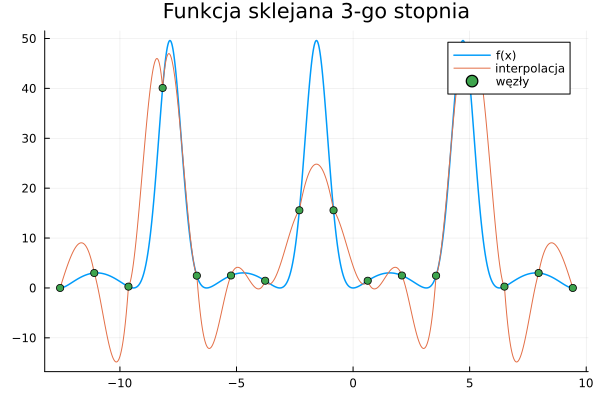

In [226]:
f = my_func
n = 15
# X, intF = get_czebyshew_and_spline(A, B, f, n, cubic_spline_interpolation, clamped_boundary) 
# X, intF = get_czebyshew_and_spline(A, B, f, n, cubic_spline_interpolation, free_boundary) 
# X, intF = get_czebyshew_and_spline(A, B, f, n, cubic_spline_interpolation, not_a_knot_boundary) 
X, intF = get_nodes_and_spline(A, B, f, n, cubic_spline_interpolation, free_boundary) 
drawInterpolation(X, f, intF, "Funkcja sklejana 3-go stopnia")
# savefig("plots/SpliBonClamp")

## Funkcja sklejana 2-go stopnia

In [128]:

function quadratic_spline_interpolation(x, y, fill_edges_func=free_boundary)
    n = length(x)

    A = zeros(n,n)
    b = zeros(n)

    fill_edges_func(A, b, x, y)

    for i in 2:n-1
        h₁ = h(i-1, x)
        h₂ = h(i, x)
        A[i,i-1] = h₁
        A[i,i] = 2*(h₁ + h₂)
        A[i,i+1] = h₂
        b[i] = 3*((y[i+1] - y[i])/h₂ - (y[i] - y[i-1])/h₁)
    end

    σ = A \ b
    function f(xx)
        if xx < x[1] || xx > x[end]
            error("xx out of range")
        end
        i = find(xx,x)
        hi = h(i, x)
        bi = (y[i+1] - y[i])/hi - hi/2 * σ[i+1] - hi/2 * σ[i]
        ci = 1/(2*hi) * (y[i+1] - y[i] - hi * (σ[i+1] - σ[i]))
        return y[i] + bi * (xx - x[i]) + ci * (xx - x[i])^2
    end

    return f
end

x = [0, 1, 2, 3, 4]
y = [1, 3, 2, 4, 1]

p = quadratic_spline_interpolation(x, y, free_boundary)
p(1.), p(1.5), p(2.)

-2.785714285714286
-2.785714285714286
2.0


(3.0, 1.183035714285714, 2.0)

In [147]:
# funkcje pomocnicze

function  h(i, X)
    return X[i+1] - X[i]
end

function Δ(i, X, Y)
    return  (Y[i+1] - Y[i]) / h(i, X)
end

function find(x, X)
    if x < X[1]
        return 1
    end
    for i in 1:length(X)-1
        if x < X[i+1]
            return i
        end
    end
    return length(X)-1
end

function free_boundary(A, b, x, y)
    n = length(x)
    A[1,1] = 1.0
    b[1] = 0.0

    A[n,n] = 1.0
    b[n] = 0
end

function quadratic_spline_interpolation(x, y, fill_edges_func=free_boundary)
    n = length(x)

    A = zeros(n,n)
    b = zeros(n)

    fill_edges_func(A, b, x, y)

    for i in 2:n-1
        h₁ = h(i-1, x)
        h₂ = h(i, x)
        A[i,i-1] = h₁
        A[i,i] = 2*(h₁ + h₂)
        A[i,i+1] = h₂
        b[i] = 3*((y[i+1] - y[i])/h₂ - (y[i] - y[i-1])/h₁)
    end

    σ = A \ b

    function f(xx)
        if xx < x[1] || xx > x[end]
            error("xx out of range")
        end
        i = find(xx,x)
        hi = h(i, x)
        bi = (y[i+1] - y[i])/hi - (hi/2) * (σ[i+1] + 2σ[i])
        ci = (σ[i+1] - σ[i]) / (6hi)
        return y[i] + bi * (xx - x[i]) + ci * (xx - x[i])^2
    end

    return f
end

x = [0, 1, 2, 3, 4]
y = [1, 3, 2, 4, 1]

p = quadratic_spline_interpolation(x, y, free_boundary)
p(1.), p(1.5), p(2.)

(3.0, 4.0, 2.0)

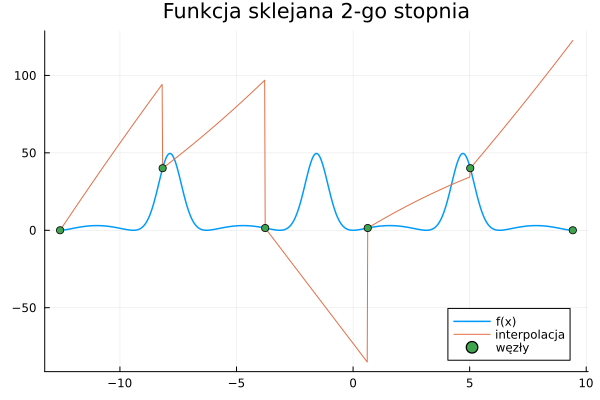

In [148]:
f = my_func
n = 5
X, intF = get_nodes_and_spline(A, B, f, n, quadratic_spline_interpolation, free_boundary) 
drawInterpolation(X, f, intF, "Funkcja sklejana 2-go stopnia")
# savefig("plots/ROn$n")